In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import timeit
import time
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import os
from __future__ import division, print_function
import shutil
%matplotlib inline
import glob
import torchvision.transforms as T
from torchvision import utils
import scipy.misc as m
from tqdm import tqdm

In [2]:
# The model FCNS 32
class fcns32(nn.Module):
    
    
    def __init__(self, n_classes =21, learn_bilinear=False):
        super(fcns32, self).__init__()
        self.learn_bilinear = learn_bilinear
        self.n_classes = n_classes
        
        # Creating the convolutional blocks
        self.conv1block = nn.Sequential(
                            nn.Conv2d(3, 64, 3, padding=100),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(64, 64, 3, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2, stride=2, ceil_mode=True),
                            )
        self.conv2block = nn.Sequential(
                            nn.Conv2d(64, 128, 3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(128, 128, 3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(2, stride=2, ceil_mode=True),)
        self.conv3block = nn.Sequential(
                            nn.Conv2d(128, 256, 3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(256,256,3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(256,256,3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(2, stride=2, ceil_mode=True),
                            )
        self.conv4block = nn.Sequential(
                            nn.Conv2d(256, 512, 3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(512,512,3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(512,512,3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(2, stride=2, ceil_mode=True),
                            )
        self.conv5block = nn.Sequential(
                            nn.Conv2d(512, 512, 3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(512,512,3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(512,512,3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(2, stride=2, ceil_mode=True),
                            )
        
        self.classifier = nn.Sequential(
                            nn.Conv2d(512, 4096, 7),
                            nn.ReLU(inplace=True),
                            nn.Dropout2d(),
                            nn.Conv2d(4096, 4096, 1),
                            nn.ReLU(inplace=True),
                            nn.Dropout2d(),
                            nn.Conv2d(4096, n_classes, 1),
                            )
        
    
    # The forward pass
    def forward(self, x):
        conv1 = self.conv1block(x)
        conv2 = self.conv2block(conv1)
        conv3 = self.conv3block(conv2)
        conv4 = self.conv4block(conv3)
        conv5 = self.conv5block(conv4)
        
        output = self.classifier(conv5)
        
        out = F.upsample(output, x.size()[2:])
        
        return out
    
    #Using the pretrained network
    def init_vgg16_params(self, vgg16, copy_fc8=True):
        blocks = [self.conv1block,
                 self.conv2block,
                 self.conv3block,
                 self.conv4block,
                 self.conv5block]
        
        ranges = [[0,4], [5,9], [10, 16], [17, 23], [24, 29]]
        features = list(vgg16.features.children())
        print(features)
        
        for i, conv in enumerate(blocks):
            for l1, l2 in zip(features[ranges[i][0]:ranges[i][1]], conv):
                if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                    print(l1.weight.size(), i)
                    print(l2.weight.size(), i)
                    assert l1.weight.size() == l2.weight.size()
                    assert l1.bias.size() == l2.bias.size()
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data
        
        for i1, i2 in zip([0,3], [0,3]):
            l1 = vgg16.classifier[i1]
            l2 = self.classifier[i2]
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())
            
        n_class = self.classifier[6].weight.size()[0]
        
        if copy_fc8:
            l1 = vgg16.classifier[6]
            l2 = self.classifier[6]
            l2.weight.data = l1.weight.data[:n_class, :].view(l2.weight.size())
            l2.bias.data = l1.bias.data[:n_class]

In [3]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
                
        running_loss = 0.0
        running_corrects = 0
            
        for data in dataloader:
            inputs, labels = data['image'], data['target']
            inputs, labels =  Variable(inputs), Variable(labels)
                
            # Zero the parameter gradients
            optimizer.zero_grad()
                
            #Forward Pass
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.data[0]
        
        epoch_loss = running_loss / len(train_images)
        
        print('Loss: {:.4f}'.format(epoch_loss))

    return model

In [5]:
model = fcns32()
vgg16 = models.vgg16(pretrained=True)
model.init_vgg16_params(vgg16)
criterion = nn.NLLLoss2d()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=0.7, gamma=0.1)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 

In [6]:
# Data collection for training set

trainText = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/ImageSets/Segmentation/train.txt'

def getTrainNames(filename):
    segment_images = []
    f = open(filename)
    filecontents = f.readlines()
    for line in filecontents:
        img_name = line.strip('\n')
        segment_images.append(img_name)
    return segment_images

In [7]:
train_images = getTrainNames(trainText)
print(len(train_images))

1464


In [8]:
if not os.path.exists('/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'):
    os.makedirs('/Users/navneetmkumar/Documents/Paper Implementations/train-inputs')

if not os.path.exists('/Users/navneetmkumar/Documents/Paper Implementations/train-targets'):
    os.makedirs('/Users/navneetmkumar/Documents/Paper Implementations/train-targets')

image_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/JPEGImages'
targets_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/SegmentationClass'

def copyFiles(directory, targets=False):
    for f in os.listdir(directory):
        f_name = os.path.basename(f)
        f_name = f_name.split(".")[0]
        if f_name in train_images:
            f = os.path.join(directory, f)
            if targets:
                shutil.copy2(f, '/Users/navneetmkumar/Documents/Paper Implementations/train-targets/')
            else:
                shutil.copy2(f, '/Users/navneetmkumar/Documents/Paper Implementations/train-inputs/')

In [9]:
copyFiles(image_dir)

In [10]:
copyFiles(targets_dir, targets=True)

In [11]:
# Setting up the validation set
valText = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/ImageSets/Segmentation/val.txt'
val_images = getTrainNames(valText)
print(len(val_images))

1449


In [12]:
if not os.path.exists('/Users/navneetmkumar/Documents/Paper Implementations/val-inputs'):
    os.makedirs('/Users/navneetmkumar/Documents/Paper Implementations/val-inputs')

if not os.path.exists('/Users/navneetmkumar/Documents/Paper Implementations/val-targets'):
    os.makedirs('/Users/navneetmkumar/Documents/Paper Implementations/val-targets')

image_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/JPEGImages'
targets_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/SegmentationClass'

def copyFiles(directory, targets=False):
    for f in os.listdir(directory):
        f_name = os.path.basename(f)
        f_name = f_name.split(".")[0]
        if f_name in val_images:
            f = os.path.join(directory, f)
            if targets:
                shutil.copy2(f, '/Users/navneetmkumar/Documents/Paper Implementations/val-targets/')
            else:
                shutil.copy2(f, '/Users/navneetmkumar/Documents/Paper Implementations/val-inputs/')

In [13]:
copyFiles(image_dir)

In [14]:
copyFiles(targets_dir, targets=True)

In [15]:
# Display the validation images
val_im_dir = '/Users/navneetmkumar/Documents/Paper Implementations/val-inputs'
val_t_dir = '/Users/navneetmkumar/Documents/Paper Implementations/val-targets'

val_im_list = glob.glob(os.path.join(val_im_dir, '*.jpg'))
val_t_list = glob.glob(os.path.join(val_t_dir, '*.png'))

def showImage(image, dire):
    f = os.path.join(dire, image)
    plt.imshow(io.imread(f))

In [16]:
# Converting the training set into tensors
class ToTensor(object):
    # Convert ndarrays in sample to Tensors
    
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2,0,1))
        target = target.transpose((2,0,1))
        return {'image': torch.from_numpy(image),
                'target': torch.from_numpy(target)}

In [7]:
class PascalVOCDataset(Dataset):
    def __init__(self, train_images_dir, train_targets_dir, img_size=512, is_transform=None):
        self.train_images_dir =  train_images_dir
        self.train_targets_dir = train_targets_dir
        self.is_transform = is_transform
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 21
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        
        if not os.path.isdir('/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/SegmentationClass/pre_encoded'):
            self.setup(pre_encode=True)
        else:
            self.setup(pre_encode=False)
        self.pre_encoded = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/SegmentationClass/pre_encoded'
        
    def __len__(self):
        train_images = sorted(glob.glob(os.path.join(self.train_images_dir, '*.jpg')))
        return len(train_images)
    
    def __getitem__(self, i):
        train_im_list = sorted(glob.glob(os.path.join(self.train_images_dir, '*.jpg')))
        train_t_pre_list = sorted(glob.glob(os.path.join(self.pre_encoded, '*.png')))
        f1 = train_im_list[i]
        f2 = train_t_pre_list[i]
        image = m.imread(f1)
        image= np.array(image, dtype=np.uint8)
        target = m.imread(f2)
        target = np.array(target, dtype=np.int32)
        sample = {'image': image, 'target': target}
        if self.is_transform:
            sample = self.transform(sample)
        return sample
    
    def transform(self, sample):
        img = sample['image']
        lbl = sample['target']
        img = img[:, :, ::-1]
        img = img.astype(np.float64)
        img -= self.mean
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))
        # Resize scales images from 0 to 255, thus we need
        # to divide by 255.0
        img = img.astype(float) / 255.0
        # NHWC -> NCWH
        img = img.transpose(2, 0, 1)
        
        lbl[lbl==255] = 0
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), 'nearest', mode='F')
        lbl = lbl.astype(int)
        
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        sample  = {'image': img, 'target': lbl}
        return sample
    
    
    # Define the 21 classes of color represeneted in pascal voc
    def get_pascal_labels(self):
        return np.asarray([[0,0,0], [128,0,0], [0,128,0], [128,128,0], [0,0,128], [128,0,128],
                              [0,128,128], [128,128,128], [64,0,0], [192,0,0], [64,128,0], [192,128,0],
                              [64,0,128], [192,0,128], [64,128,128], [192,128,128], [0, 64,0], [128, 64, 0],
                              [0,192,0], [128,192,0], [0,64,128]])
        
    
    # Encoding the target ( since the loss function will only take a long tensor)
    def encode_segmap(self, mask):
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for i, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = i
        label_mask = label_mask.astype(int)
        return label_mask
    
    def decode_segmap(self, temp, plot=False):
        label_colours = self.get_pascal_labels()
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r
        rgb[:, :, 1] = g
        rgb[:, :, 2] = b
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup(self, pre_encode=False):
        
        train_t_list = sorted(glob.glob(os.path.join(self.train_targets_dir, '*.png')))

        target_path = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2012/SegmentationClass/pre_encoded/'
        if not os.path.exists(target_path):
            os.makedirs(target_path)

        if pre_encode:
            print("Pre-encoding segmentation masks...")

            for i in tqdm(range(len(train_t_list))): 
                lbl = self.encode_segmap(m.imread(train_t_list[i]))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(target_path + str(i) + '.png', lbl)    

In [8]:
train_images_dir ='/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'
train_targets_dir = '/Users/navneetmkumar/Documents/Paper Implementations/train-targets'
data = PascalVOCDataset(train_images_dir, train_targets_dir, is_transform=True)

In [9]:
# Instead of using a simple for loop we will be using the torch.utils.DataLoader
# It provides the following features:
# 1.Batching the data
# 2.Shuffling the data
# 3.Load data in parallel using multiprocessing workers

dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4)

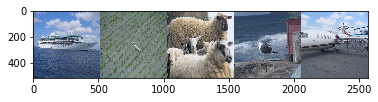

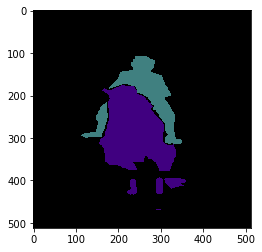

In [81]:
for i_batch, sample_batched in enumerate(dataloader):
    imgs, labels = sample_batched['image'], sample_batched['target']
    if i_batch == 0:
            img = torchvision.utils.make_grid(imgs).numpy()
            img = np.transpose(img, (1, 2, 0))
            img = img[:, :, ::-1]
            plt.imshow(img)
            plt.show()
            plt.imshow(data.decode_segmap(labels.numpy()[i_batch+1]))
            plt.show()

In [ ]:
model = train_model(model, optimizer, criterion, lr_scheduler)

Epoch 0/24
----------
